In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
recent_date

'2017-08-23'

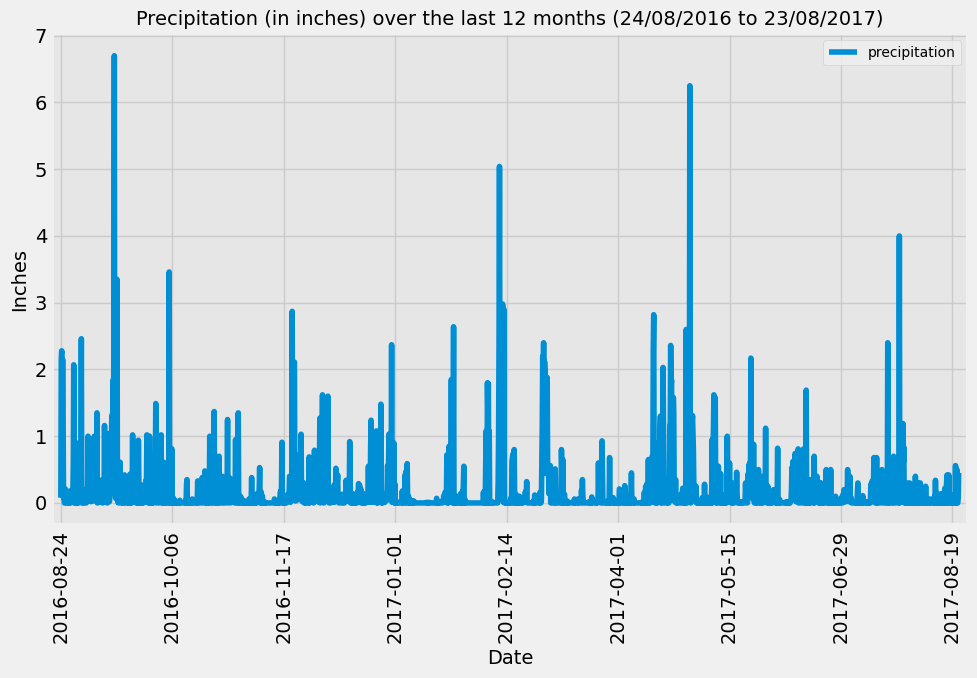

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
past_year_data = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= past_year_data).\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_db = pd.DataFrame(precipitation, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
precipitation_db = precipitation_db.sort_index(ascending = True).dropna()

# Use Pandas Plotting with Matplotlib to plot the data
Fig1 = precipitation_db.plot(figsize=(10,7), fontsize=14, rot=90)
Fig1.set_xlim(-20, len(precipitation_db)+20)
plt.xlabel("Date", size=14)
plt.ylabel("Inches", size=14)
plt.title("Precipitation (in inches) over the last 12 months (24/08/2016 to 23/08/2017)", size=14)
Fig1.set_facecolor('0.9')
plt.grid(True, alpha=1.0)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('Images/Fig1.png')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_db.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(f"There are {total_stations} stations in the dataset.")

There are 9 stations in the dataset.


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Design a query to find the most active station
most_active_station = active_stations[0][0]

# Show the most active station
print(f"{most_active_station} is the most active station.")

USC00519281 is the most active station.


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

most_active_station_temp = session.query(*sel).\
                                   filter(Measurement.station == most_active_station).all()
print(f"The lowest temperature at {most_active_station} is {most_active_station_temp[0][0]} degrees Fahrenheit.")
print(f"The highest temperature at {most_active_station} is {most_active_station_temp[0][1]} degrees Fahrenheit.")
print(f"The average temperature at {most_active_station} is {round(most_active_station_temp[0][2], 2)} degrees Fahrenheit.")

The lowest temperature at USC00519281 is 54.0 degrees Fahrenheit.
The highest temperature at USC00519281 is 85.0 degrees Fahrenheit.
The average temperature at USC00519281 is 71.66 degrees Fahrenheit.


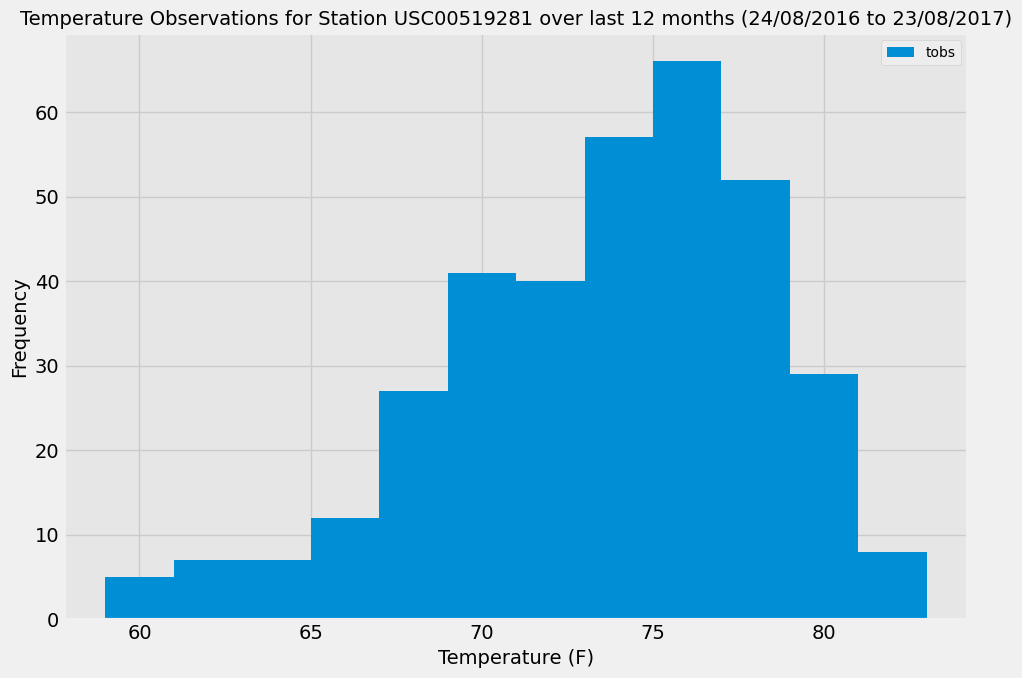

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_data = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date >= past_year_data).\
                    order_by(Measurement.date).all()
station_temp_db = pd.DataFrame(station_temp_data)
station_temp_db.head()

# Plot the histogram

Fig2 = station_temp_db.plot(kind='hist', bins=12, fontsize=14, figsize=(10,7))

plt.xlabel("Temperature (F)", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Temperature Observations for Station USC00519281 over last 12 months (24/08/2016 to 23/08/2017)", size=14)

Fig2.set_facecolor('0.9')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=1.0)
plt.tight_layout()

# Save the chart image
plt.savefig('Images/Fig2.png')

# Show the chart
plt.show()

# Close Session

In [18]:
# Close Session
session.close()